<a href="https://colab.research.google.com/github/JyzMinaBF/CriminalLaw/blob/main/Criminal_Law_Model_GoGoGo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 讀入使用套件

第一輪是讀進我們基本套件, 第二輪是 TensorFlow 用到的套件。

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import pickle
import keras.preprocessing.text
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM


from tensorflow.keras.models import load_model, model_from_json

### 2. 讀入訓練好的 RNN 刑法生成器

老師的是參考[《精通機器學習-使用 Scikit-Learn, Keras 與 TensorFlow》](https://www.books.com.tw/products/0010854043?sloc=main)這本書中莎士比亞生成器的部份寫成的。架構很簡單,就每輸入 100 個字, 預測下一個字是什麼。雙層 LSTM, 每層 128 個神經元。訓練 10 次, 在 1080Ti GPU 的電腦上大概花了 10 個小時。

# 第一個改動

然後我，真的也自己搞了一個QQ

它花了我超久的時間嗚嗚嗚嗚

製作的該模型連結是https://colab.research.google.com/drive/1VAuPXGcAxd-ysSeT4qirhVs2qss5D3h8#scrollTo=ERLFn6X7imLI

如果可以也希望你能看在我跑到快吐的情況下進去看看，然後因為這個給我5分，拜託了

（這個花了我超過10個小時，都快哭了）

以下就是從我的 GitHub 重新讀入模型。


In [ ]:
from urllib.request import urlretrieve


# 第二個改動

下面這邊全部是我自己照老師的模版研究的，也是我盡力製作的，也因此整個連結，讀取資訊等也完全不一樣




In [ ]:
urlretrieve("https://raw.githubusercontent.com/JyzMinaBF/CriminalLaw/main/CriminalLaw_rnn.json", "architecture.json")
urlretrieve("https://github.com/JyzMinaBF/CriminalLaw/raw/main/CriminalLaw_rnn_weights.h5", "weights.h5")
urlretrieve("https://github.com/JyzMinaBF/CriminalLaw/raw/main/law1.pkl", "Criminal.pkl")

('Criminal.pkl', <http.client.HTTPMessage at 0x7fa1722fcf50>)

In [ ]:
f = open('architecture.json', 'r')
loaded_model = f.read()
f.close()

In [ ]:
model = model_from_json(loaded_model)

In [ ]:
model.load_weights("weights.h5")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         563712    
                                                                 
 time_distributed (TimeDistr  (None, None, 972)        125388    
 ibuted)                                                         
                                                                 
Total params: 689,100
Trainable params: 689,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
f = open('Criminal.pkl', 'rb')
CriminalLaw = pickle.load(f)
f.close()

### 3. 製造刑法生成器

首先 `max_id` 是記錄《刑法》用到的所有不同的中文字字數, 包括新式標點符號。不出所料的，才971個字而已哈哈哈哈

# 第三個改動

然而，在這邊，有個我極度重大的改動

在老師的版本中，它的文字一開始就是以Keras的text形式存在，但我的是純String，所以要先做轉換

In [ ]:
tokenizer=keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(CriminalLaw)

In [ ]:
''.join(tokenizer.sequences_to_texts([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])[0].split())

'，之以或。者刑、下期有年處徒一'

In [ ]:
tokenizer.texts_to_sequences("行為之處罰")

[[20], [29], [2], [13], [17]]

In [ ]:
max_id = len(tokenizer.word_index)
print(max_id)

972


接下來是一段文字, 我們用事先訓練好的 tokenizer 換成一段數字, 最後用 one-hot encoding 回傳。

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences([texts]))-1
    return tf.one_hot(X, max_id)

這段程式主要依輸入的一段文字, 用我們的 model 去預測下一個字。注意像平常的分類問題, 這裡輸出是每人個字出現機率最高的。但都照這樣, 我們輸入同一段文字, 之後出現的文字永遠是一樣的! 常用的手法是去設定 `temperature`, `temperature` 接近 0, 大致上就取機率最高的字; `temperature` 越大就越隨機。太隨機就變成亂數取字! 一般 `temperature`設 1 左右效果最佳。

# 第四個改動

然而因為我的刑法字數沒有那麼多，為了讓他不會每次都看起來完全一樣，我把`temperature`略調高到1.2

In [ ]:
def next_char(texts, temperature=1.2):
    X_new = preprocess(texts)
    y_predict = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_predict) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

最後就一段文字進來，再產生 `n_chars` 這麼多個字。我們原本一段文字只能生一個字, 那就一次生一個字, 最後要生多少個字就生多少個字。

原本訓練我們一段是 100 個字去訓練的, 這裡超過 100 字時我們就取最後 100 個字丟入模型。

In [ ]:
def complete_text(texts, n_chars=50, temperature=1.2):
    n_chars=int(n_chars)
    for _ in range(n_chars):
        texts = texts + next_char(texts[-100:], temperature)
    return texts

# 第四點五個改動

做成 web app 前, 測試的值改一下。

In [ ]:
complete_text('唯一死刑')

'唯一死刑或無期徒刑；致重傷者，處無期徒刑或七年以上有期徒刑。致重傷者，處三年以下有期徒刑。對於直系血親尊親屬'

### 4. 用 `gradio` 做成一個網路 app

我們準備用 [`gradio`](https://gradio.app/) 套件, 神速做完一個 web app。最酷的是, 最後出現 `https://xxxx.gradio.app` 那個網址, 在你的 Colab 還在執行的時候, 任何人都可以用任何瀏覽器連進來使用!

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# 第五個改動

把Gradio內的敘述做改變，讓看的人可以了解

In [ ]:
iface = gr.Interface(
    fn=complete_text,
    inputs=[
        "text",
        gr.inputs.Slider(50, 200, 1, 50),
        gr.inputs.Slider(0.2, 2, 0.2, 1)],
    outputs="text",
    title="刑法生成器",
    description="起個頭, 幫你完成一段刑法Style的敘述。可以改變 temperature, 越小生出的字越固定, 越大越隨機。")
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://26546.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fa17530ec10>,
 'http://127.0.0.1:7861/',
 'https://26546.gradio.app')

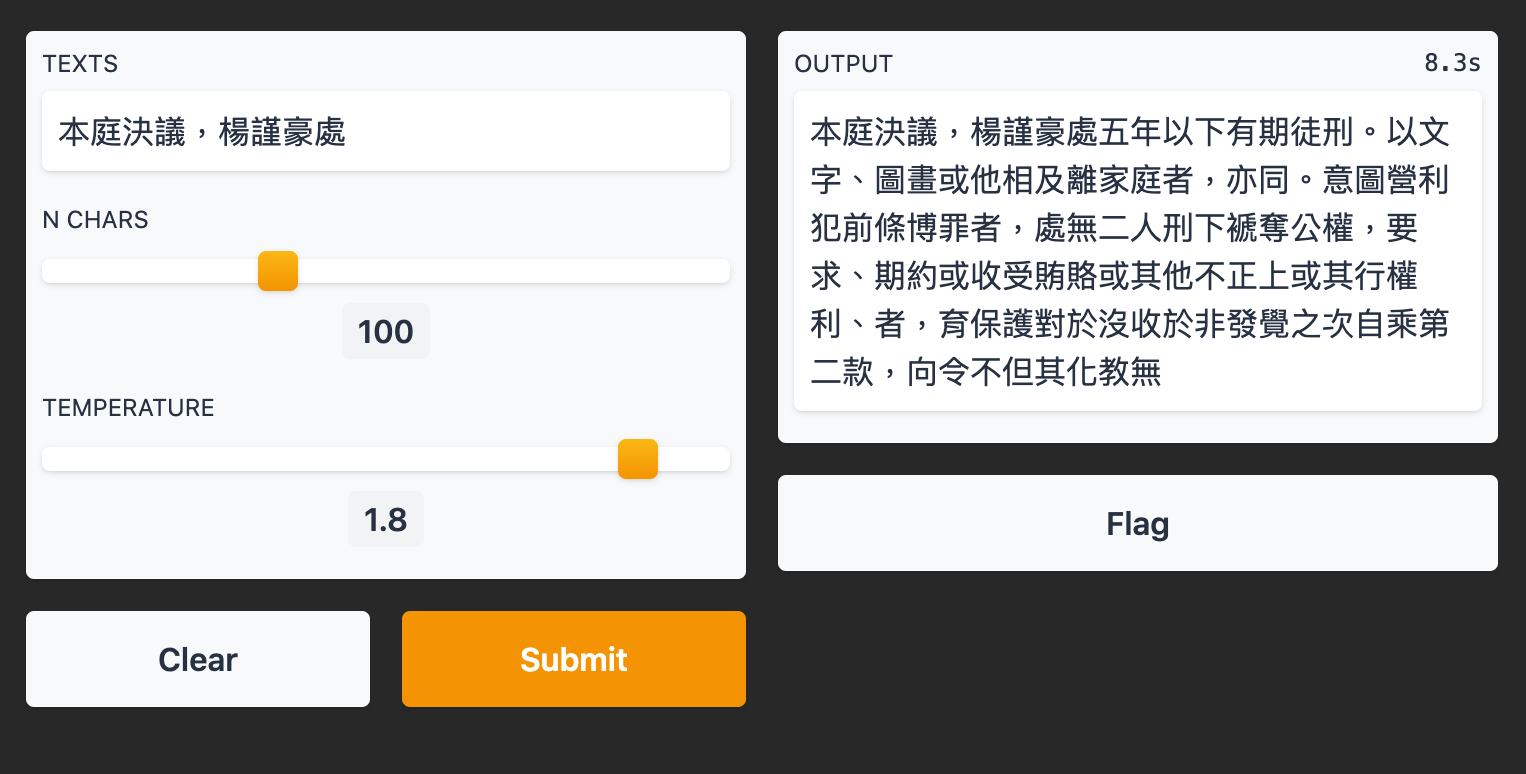